# C14-hepatocyte analysis

In [1]:
# m = c14.models.liver.A()

# path = c14.models.liver.default_path

# from scipy.interpolate import UnivariateSpline

# ploidy_data = pd.read_excel(path)
# ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
#                       mean(axis='columns'))
# ploidy_data /= 100.0
# ploidy_data['age'] *= 100

# ploidy = UnivariateSpline(ploidy_data['age'].values,
#                                ploidy_data['2C_mean'].values,
#                                ext=3, k=2)

# t = np.linspace(0, 100)
# plt.plot(t, m.ploidy(t))
# plt.plot(t, ploidy(t))

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [2]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/hepato', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
# logging.basicConfig(level=logging.WARNING)

In [3]:
# logger = logging.getLogger()
# logger.setLevel(logging.WARNING)

In [4]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [5]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190827.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [6]:
edata_young = c14.exp_data(data.query('age <= 50'))
edata_old = c14.exp_data(data.query('age > 50'))

## Fit the models

In [7]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [8]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [9]:
models = c14.models.liver.models_list 
models

[c14.models.liver.A,
 c14.models.liver.D,
 c14.models.liver.Dr2lin,
 c14.models.liver.Dk24lin,
 c14.models.liver.R,
 c14.models.liver.K]

In [10]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [11]:
# %%time
# results = fit_models(edata, models, step_size=2, 
#                      optimize_minuit_multistart_kwargs=dict(n=10, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [12]:
%%time
results = fit_models(edata, models, step_size=2, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

Fitting model A
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]


/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/pksCloud/projects/C14/source/c14/c14/models/liver.py:104: RuntimeWarning: overflow encountered in multiply
  M_new[self.n4] = (-(M[self.n4]*(delta4 + kappa42 - 2*r4)) + (-(M[self.n2]*kappa24) + M[self.n4]*(delta4 + 4*kappa24 + kappa42 - 2*r4))*ploidy(t) + self.Catm.lin(Dbirth + t)*(-r4 + (-kappa24 + r4)*ploidy(t)))/(-1 + ploidy(t))
/home/fabrost/pksCloud/projects/C14/source/c14/c14/models/liver.py:104: RuntimeWarning: overflow encountered in true_divide
  M_new[self.n4] = (-(M[self.n4]*(delta4 + kappa42 - 2*r4)) + (-(M[self.n2]*kappa24) + M[self.n4]*(delta4 

Fitting model D
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]


/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_sc

Fitting model Dr2lin
[(-3, 0), (-3, 0), (-3, 0), (-3, 0), (-3, 0)]


/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Fitting model Dk24lin
[(-3, 0), (-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model R
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]
Fitting model K
[(-3, 0), (-3, 0), (-3, 0), (-3, 0)]


/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/miniconda3/envs/spols190426/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/fabrost/pksCloud/projects/C14/source/c14/c14/models/liver.py:104: RuntimeWarning: overflow encountered in multiply
  M_new[self.n4] = (-(M[self.n4]*(delta4 + kappa42 - 2*r4)) + (-(M[self.n2]*kappa24) + M[self.n4]*(delta4 + 4*kappa24 + kappa42 - 2*r4))*ploidy(t) + self.Catm.lin(Dbirth + t)*(-r4 + (-kappa24 + r4)*ploidy(t)))/(-1 + ploidy(t))
/home/fabrost/pksCloud/projects/C14/source/c14/c14/models/liver.py:104: RuntimeWarning: overflow encountered in add
  M_new[self.n4] = (-(M[self.n4]*(delta4 + kappa42 - 2*r4)) + (-(M[self.n2]*kappa24) + M[self.n4]*(delta4 + 4*kapp

CPU times: user 34.7 s, sys: 798 ms, total: 35.5 s
Wall time: 13min 23s


In [13]:
# %%time
# results_young = fit_models(edata_young, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [14]:
# %%time
# results_old = fit_models(edata_old, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [15]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[0, 80])
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [16]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

/home/fabrost/pksCloud/projects/C14/source/c14/c14/models/base.py:103: RuntimeWarning: overflow encountered in double_scalars
  p_phy[p] = 10**p_fit[p]


## Parameter Values

### Detailed

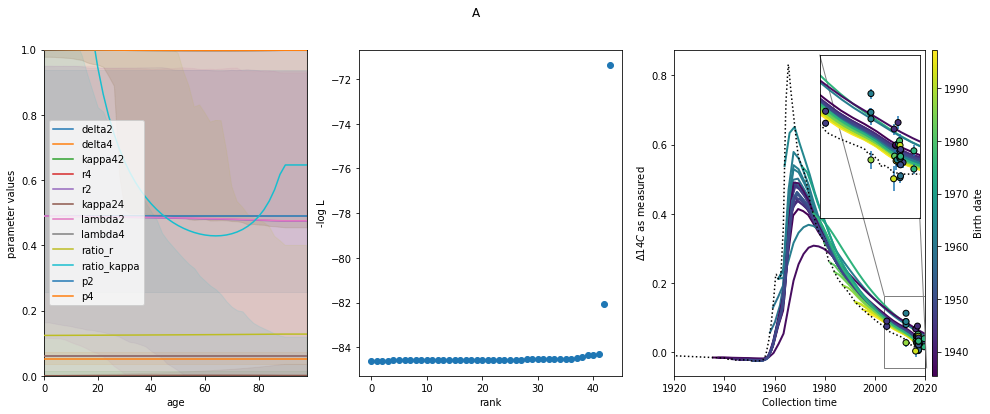

point_estimate        lower       upper
time parameter                                          
0    delta2            0.491347     0.257811    0.936428
     delta4           0.0519926    0.0364193   0.0742254
     kappa24        4.07793e-05   0.00157024  0.00466636
     kappa42        0.000597609    2.459e-05   0.0145236
     lambda2           0.489777     0.334343     1.11829
     lambda4           0.061258   0.00092265   0.0511806
     p2                0.999917     0.989362    0.998323
     p4                0.999917     0.989362    0.998323
     r2                0.489736     0.329694     1.11423
     r4               0.0606604   0.00171151     2.14996
     ratio_kappa        14.6547   0.00496851     4.73469
     ratio_r           0.123864  0.000412312   0.0747154
50   delta2            0.491347     0.257811    0.936428
     delta4           0.0519926    0.0364193   0.0742254
     kappa24          0.0012976   0.00637246   0.0151325
     kappa42        0.000597609    2.459e-05   0.0145236
     lambda2           0.484239     0.340536     1.13877
     lambda4           0.061258  0.000850492   0.0423657
     p2                 0.99732     0.965368    0.993287
     p4                 0.99732     0.965368    0.993287
     r2                0.482942     0.329869     1.12819
     r4               0.0606604   0.00171151     2.14996
     ratio_kappa        0.46055   0.00142268     1.19562
     ratio_r           0.125606  0.000395941   0.0639486
80   delta2            0.491347     0.257811    0.936428
     delta4           0.0519926    0.0364193   0.0742254
     kappa24         0.00122455    0.0136205   0.0340896
     kappa42        0.000597609    2.459e-05   0.0145236
     lambda2           0.478176     0.357847     1.16396
     lambda4           0.061258  0.000838675   0.0400919
     p2                0.997439     0.927225    0.985951
     p4                0.997439     0.927225    0.985951
     r2                0.476952     0.329952     1.13568
     r4               0.0606604   0.00171151     2.14996
     ratio_kappa       0.488024  0.000641113     0.54497
     ratio_r           0.127184  0.000392963   0.0623752

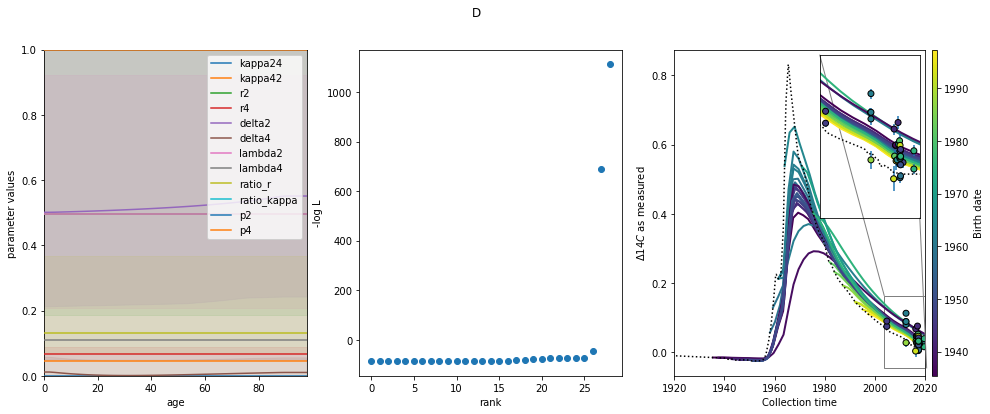

point_estimate         lower         upper
time parameter                                             
0    delta2            0.501283      0.172529      0.603568
     delta4            0.011546     0.0317644     0.0688019
     kappa24         1.1048e-60  4.43456e-288  2.75242e+167
     kappa42          0.0451046   5.58766e-08       36409.1
     lambda2           0.495672       0.17093      0.623866
     lambda4           0.110742      0.048103     0.0973472
     p2                       1             1             1
     p4                       1             1             1
     r2                0.495672      0.186908        1.3145
     r4               0.0656376     0.0495108     0.0870173
     ratio_kappa    4.08261e+58   6.51055e+07   9.23208e+62
     ratio_r           0.132421     0.0705136      0.433197
50   delta2            0.517374      0.180472      0.633408
     delta4          0.00283671     0.0230551     0.0600926
     kappa24         1.1048e-60  4.43456e-288  2.75242e+167
     kappa42          0.0451046   5.58766e-08       36409.1
     lambda2           0.495672       0.17093      0.623866
     lambda4           0.110742     0.0479095     0.0973472
     p2                       1             1             1
     p4                       1             1             1
     r2                0.495672      0.186908        1.3145
     r4               0.0656376     0.0495108     0.0870173
     ratio_kappa    4.08261e+58   6.51055e+07   9.59024e+62
     ratio_r           0.132421     0.0705136      0.433197
80   delta2            0.539802      0.186168      0.617206
     delta4          0.00863958     0.0288579     0.0655481
     kappa24         1.1048e-60  4.43456e-288  2.75242e+167
     kappa42          0.0451046   5.58766e-08       36409.1
     lambda2           0.495672       0.17093      0.601969
     lambda4           0.110742     0.0475894     0.0967607
     p2                       1             1             1
     p4                       1             1             1
     r2                0.495672      0.186908        1.3145
     r4               0.0656376     0.0495108     0.0870173
     ratio_kappa    4.08261e+58   6.87933e+07   9.59024e+62
     ratio_r           0.132421     0.0705136      0.433197

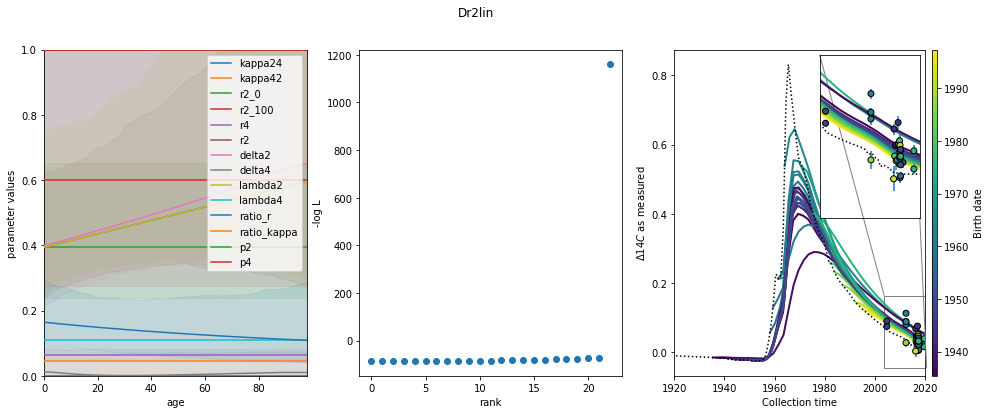

point_estimate        lower        upper
time parameter                                           
0    delta2            0.399764     0.213285     0.564711
     delta4           0.0115426    0.0261557     0.122073
     kappa24        3.66677e-13  1.43635e-28      936.065
     kappa42          0.0442387  7.73676e-05      25.2957
     lambda2            0.39423     0.214863     0.616053
     lambda4           0.109007      0.05469    0.0988477
     p2                       1     0.989947            1
     p4                       1     0.989947            1
     r2                 0.39423     0.212179     0.593361
     r2_0               0.39423     0.237769     0.653646
     r2_100             0.60034     0.273924      1.31572
     r4               0.0647684    0.0508853    0.0824391
     ratio_kappa    1.20648e+11     0.361926   3.4955e+12
     ratio_r           0.164291     0.102072     0.330912
50   delta2            0.518753     0.308837     0.929256
     delta4          0.00283331    0.0171893    0.0737723
     kappa24        3.66677e-13  1.43635e-28      936.065
     kappa42          0.0442387  7.73676e-05      25.2957
     lambda2           0.497285     0.302801     0.967375
     lambda4           0.109007    0.0546272    0.0988432
     p2                       1     0.996125            1
     p4                       1     0.996125            1
     r2                0.497285     0.301836     0.937984
     r2_0               0.39423     0.237769     0.653646
     r2_100             0.60034     0.273924      1.31572
     r4               0.0647684    0.0508853    0.0824391
     ratio_kappa    1.20648e+11     0.372022   2.9023e+12
     ratio_r           0.130244    0.0541944     0.257001
80   delta2            0.602693     0.302557      1.11512
     delta4          0.00863618    0.0275636    0.0719674
     kappa24        3.66677e-13  1.43635e-28      936.065
     kappa42          0.0442387  7.73676e-05      25.2957
     lambda2           0.559118       0.2837      1.11093
     lambda4           0.109007    0.0543606    0.0971343
     p2                       1     0.997187            1
     p4                       1     0.997187            1
     r2                0.559118       0.2837      1.11093
     r2_0               0.39423     0.237769     0.653646
     r2_100             0.60034     0.273924      1.31572
     r4               0.0647684    0.0508853    0.0824391
     ratio_kappa    1.20648e+11     0.377968  5.01901e+11
     ratio_r            0.11584    0.0442761     0.277336

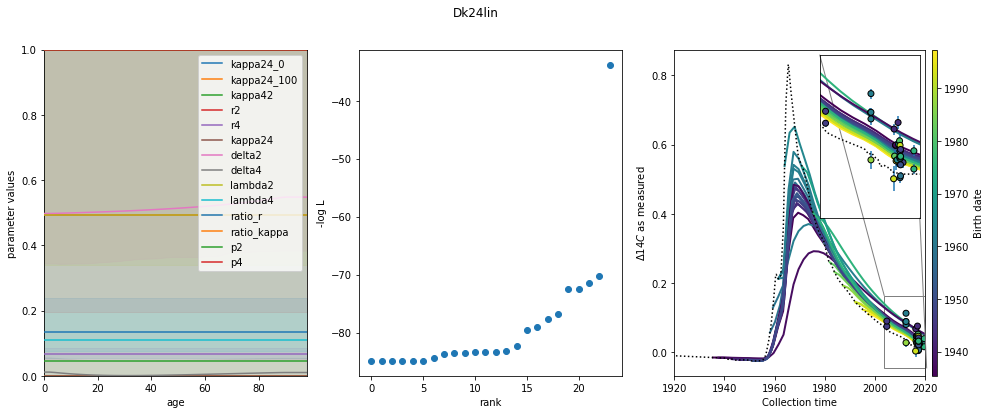

point_estimate        lower        upper
time parameter                                           
0    delta2            0.497688     0.233023     0.755525
     delta4           0.0113449    0.0315412    0.0692731
     kappa24        2.03708e-26  6.32753e-34  4.11008e-06
     kappa24_0      2.03708e-26  7.26981e-99  5.70811e+46
     kappa24_100    1.02176e-23  1.32545e-88  7.87654e+41
     kappa42          0.0453431  2.58494e-07      7953.76
     lambda2           0.492056     0.250539     0.793604
     lambda4           0.111018    0.0573774    0.0958443
     p2                       1     0.999987            1
     p4                       1     0.999987            1
     r2                0.492056     0.195742      1.23693
     r4                0.065675    0.0512697    0.0841278
     ratio_kappa    2.22589e+24      338.954  1.62401e+31
     ratio_r           0.133471    0.0713813      0.31952
50   delta2            0.513822     0.252811     0.750911
     delta4          0.00263559    0.0228319    0.0605638
     kappa24        5.11899e-24  5.01153e-30  1.36362e-05
     kappa24_0      2.03708e-26  7.26981e-99  5.70811e+46
     kappa24_100    1.02176e-23  1.32545e-88  7.87654e+41
     kappa42          0.0453431  2.58494e-07      7953.76
     lambda2           0.492056       0.2399     0.793604
     lambda4           0.111018    0.0573165    0.0958347
     p2                       1     0.999976            1
     p4                       1     0.999976            1
     r2                0.492056     0.195742      1.23693
     r4                0.065675    0.0512697    0.0841278
     ratio_kappa    8.85781e+21      208.641   4.3869e+27
     ratio_r           0.133471    0.0714031     0.320433
80   delta2            0.536339     0.269498     0.756839
     delta4          0.00843847    0.0297239    0.0663667
     kappa24        8.17817e-24  4.39854e-30  1.48942e-05
     kappa24_0      2.03708e-26  7.26981e-99  5.70811e+46
     kappa24_100    1.02176e-23  1.32545e-88  7.87654e+41
     kappa42          0.0453431  2.58494e-07      7953.76
     lambda2           0.492056     0.233611     0.793604
     lambda4           0.111018    0.0572926    0.0958347
     p2                       1     0.999969            1
     p4                       1     0.999969            1
     r2                0.492056     0.195742      1.23693
     r4                0.065675    0.0512697    0.0841278
     ratio_kappa    5.54441e+21      166.997  3.31699e+27
     ratio_r           0.133471    0.0714031     0.321329

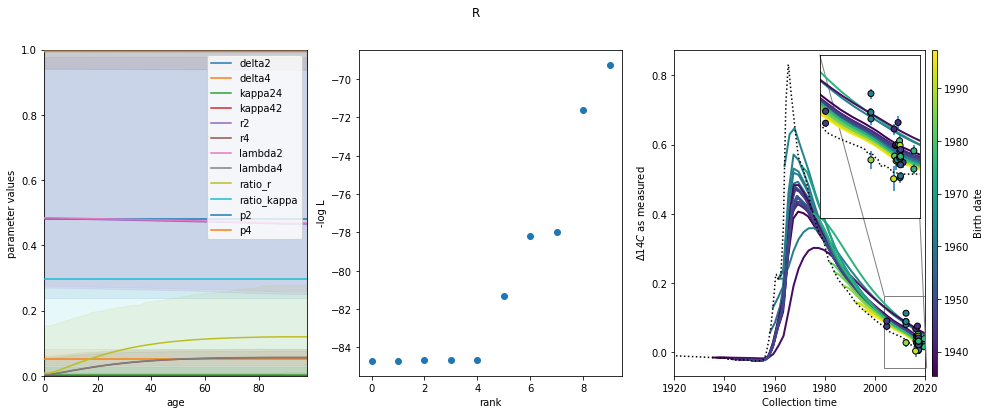

point_estimate        lower       upper
time parameter                                          
0    delta2            0.481215     0.237018    0.977003
     delta4           0.0506026    0.0317437   0.0806656
     kappa24         0.00250839  0.000239102   0.0263152
     kappa42        0.000746922  7.79349e-05  0.00715843
     lambda2           0.484566     0.263898    0.958956
     lambda4         0.00468578    0.0186649   0.0666514
     p2                0.994823     0.978864    0.999603
     p4                0.994823     0.978864    0.999603
     r2                0.482058     0.257785    0.958759
     r4              0.00393886    0.0160888    0.060369
     ratio_kappa        0.29777    0.0272436     14.0222
     ratio_r         0.00817093    0.0219214    0.195836
50   delta2            0.481215     0.237018    0.977003
     delta4           0.0506026    0.0317437   0.0806656
     kappa24         0.00250839  0.000239102   0.0263152
     kappa42        0.000746922  7.79349e-05  0.00715843
     lambda2           0.476488      0.25012    0.970189
     lambda4          0.0511844    0.0467415   0.0897583
     p2                0.994736     0.987134    0.999693
     p4                0.994736     0.987134    0.999693
     r2                 0.47398     0.248397    0.964134
     r4               0.0504375    0.0442617   0.0834159
     ratio_kappa        0.29777    0.0419199      18.069
     ratio_r           0.106413    0.0505828    0.314004
80   delta2            0.481215     0.237018    0.977003
     delta4           0.0506026    0.0317437   0.0806656
     kappa24         0.00250839  0.000239102   0.0263152
     kappa42        0.000746922  7.79349e-05  0.00715843
     lambda2           0.470516     0.247903    0.941578
     lambda4          0.0561582    0.0491157   0.0903968
     p2                0.994669     0.994484    0.999821
     p4                0.994669     0.994484    0.999821
     r2                0.468008     0.246115    0.939853
     r4               0.0554113    0.0459952   0.0856206
     ratio_kappa        0.29777    0.0985071     41.3734
     ratio_r           0.118398    0.0523234     0.34559

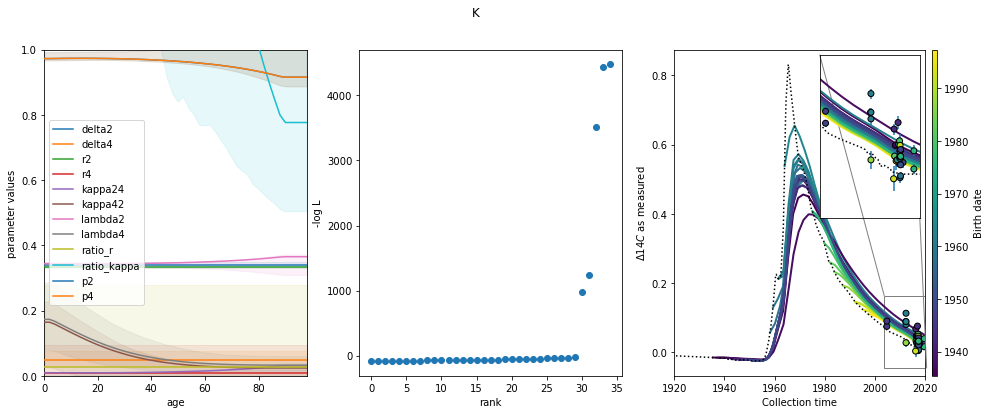

point_estimate        lower      upper
time parameter                                         
0    delta2            0.341056     0.334395   0.347849
     delta4            0.047424    0.0297592  0.0755746
     kappa24         0.00942547   0.00541447  0.0121693
     kappa42           0.164271    0.0616677   0.227868
     lambda2           0.343695      0.33803   0.347392
     lambda4           0.173034     0.068047   0.263449
     p2                0.972576     0.964788    0.98408
     p4                0.972576     0.964788    0.98408
     r2                 0.33427     0.330681   0.337898
     r4              0.00876295  0.000816048   0.094099
     ratio_kappa        17.4284      11.3419    20.9973
     ratio_r          0.0262152   0.00231178   0.130256
50   delta2            0.341056     0.334395   0.347849
     delta4            0.047424    0.0297592  0.0755746
     kappa24          0.0124379   0.00824339  0.0154403
     kappa42          0.0359127    0.0121064  0.0504977
     lambda2           0.346708     0.341571   0.348844
     lambda4          0.0446757    0.0183065  0.0707948
     p2                0.964126     0.955312   0.975986
     p4                0.964126     0.955312   0.975986
     r2                 0.33427     0.330681   0.337898
     r4              0.00876295  0.000816048   0.094099
     ratio_kappa        2.88736      1.19378    4.08597
     ratio_r          0.0262152   0.00260824   0.088118
80   delta2            0.341056     0.334395   0.347849
     delta4            0.047424    0.0297592  0.0755746
     kappa24          0.0239324    0.0149967  0.0317251
     kappa42          0.0241676    0.0111462  0.0329281
     lambda2           0.358202      0.34903   0.364198
     lambda4          0.0329305    0.0171256   0.048783
     p2                0.933187     0.912332   0.957025
     p4                0.933187     0.912332   0.957025
     r2                 0.33427     0.330681   0.337898
     r4              0.00876295  0.000816048   0.094099
     ratio_kappa        1.00983     0.702182    1.18993
     ratio_r          0.0262152   0.00309621  0.0704375

In [17]:
for name, result in results.items():
    if name not in ['']:
        if name[-4:] == 'step':
            no_plot = ['delta', 'lambda_']
        else:
            no_plot = ['delta']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80]
                                               ))
        except:
            pass

### Summarized

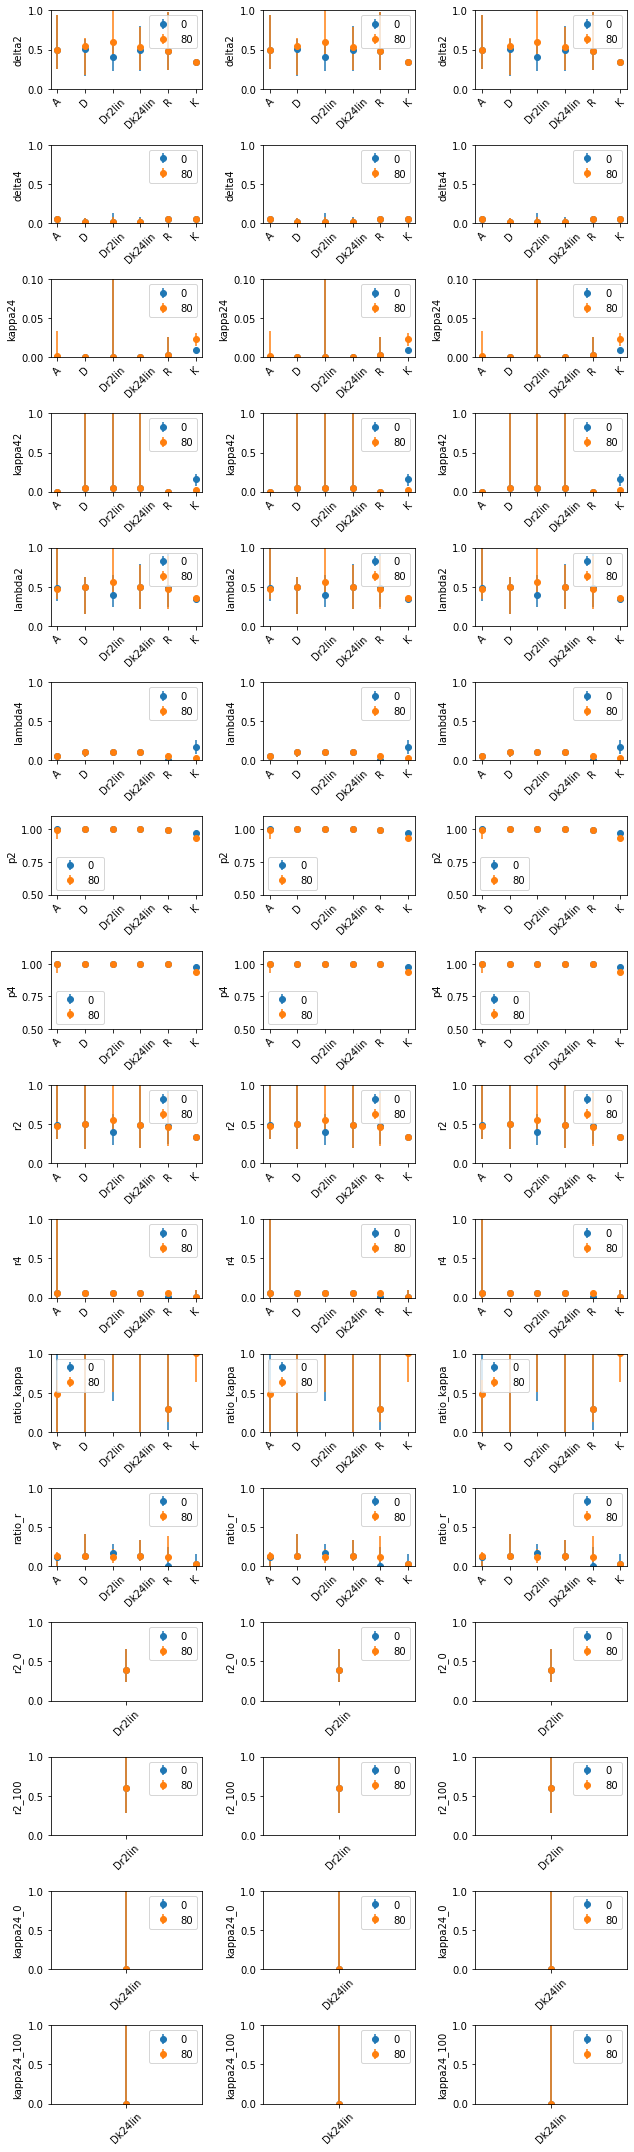

In [20]:
p_names = parameters['parameter'].unique()
paras = 3*[parameters]
fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.1)}

for parameter, axs in zip(p_names, axss):
    for para, ax in zip(paras, axs):
        data = para[para['parameter'] == parameter]
        for time, time_data in data.groupby('time'):
            ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                        data=time_data, marker='o', ls='None', label=time)
            ax.legend()
            ax.set_ylabel(parameter)
        try:
            ax.set_ylim(ylimits[parameter])
        except:
            ax.set_ylim(0, 1)
        ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Export

In [ ]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [19]:
model_selection_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
D,-157.582546,84.902384,5,0.000000,0.307865,1.000000
R,-157.169341,84.695782,5,0.413205,0.250400,1.229494
A,-156.992617,84.607420,5,0.589929,0.229223,1.343079
K,-154.741700,83.481961,5,2.840846,0.074384,4.138872
Dr2lin,-154.613178,84.921974,6,2.969368,0.069754,4.413571
Dk24lin,-154.573227,84.901998,6,3.009319,0.068375,4.502619
